# Answer Type Result Anlaysis

In [3]:
import sys
sys.path.append("../torch_based")

import json
import torch

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from utils import plot_confusion_matrix

In [10]:
def eval_answer_type_result(pred_file, ground_truth_file="../input/tensorflow2-question-answering/cached_dev_pytorch_model.bin_512", idx2label = ["unknown", "yes", "no", "short", "long"]):
    with open(pred_file, "r") as f:
        predictions = json.load(f)
        
    
    _, examples = torch.load(ground_truth_file)
    id2label = {}
    for e in tqdm(examples, desc="Creating examples dict"):
        id2label[e.example_id] = int(e.answer.type)
    
    y_true_list, y_pred_list = [], []
    for pred in tqdm(predictions['predictions'], desc="Creating y_true and y_pred"):
        y_pred_list.append(pred['answer_type'])

        y_true = id2label[pred["example_id"]]
        y_true_list.append(y_true)
    
    print(classification_report(y_true_list, y_pred_list, target_names=idx2label))
    
    cm = confusion_matrix(y_true_list,y_pred_list)
    plot_confusion_matrix(cm, classes=idx2label, normalize=False)
    

## Round 1 for bert-large-uncased-whole-word-masking-finetuned-squad (12/20/2019)

Creating y_true and y_pred: 100%|██████████| 1600/1600 [00:00<00:00, 506941.11it/s]


              precision    recall  f1-score   support

     unknown       0.82      0.33      0.47       481
         yes       0.52      0.84      0.64        19
          no       0.14      0.17      0.15        12
       short       0.72      0.86      0.78       873
        long       0.29      0.43      0.34       215

    accuracy                           0.63      1600
   macro avg       0.50      0.52      0.48      1600
weighted avg       0.69      0.63      0.62      1600

Confusion matrix, without normalization


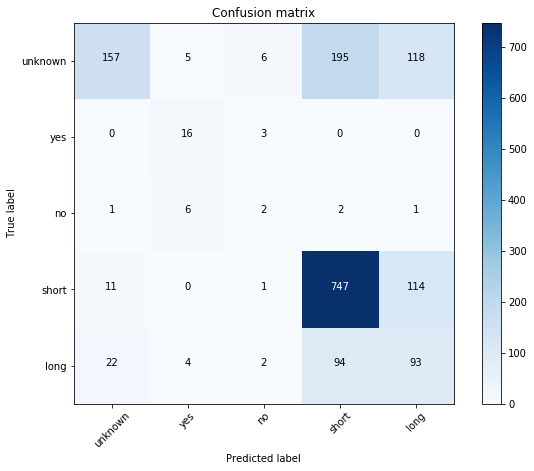

In [11]:
eval_answer_type_result("../output/predictions_ccj.json")

## Round 2 for albert-xxlarge-tfidf-600-top8-V0 (12/31/2019)

Creating y_true and y_pred: 100%|██████████| 1600/1600 [00:00<00:00, 481170.60it/s]


              precision    recall  f1-score   support

     unknown       0.66      0.59      0.62       481
         yes       0.67      0.53      0.59        19
          no       0.31      0.33      0.32        12
       short       0.81      0.78      0.79       873
        long       0.31      0.43      0.36       215

    accuracy                           0.67      1600
   macro avg       0.55      0.53      0.54      1600
weighted avg       0.69      0.67      0.68      1600

Confusion matrix, without normalization


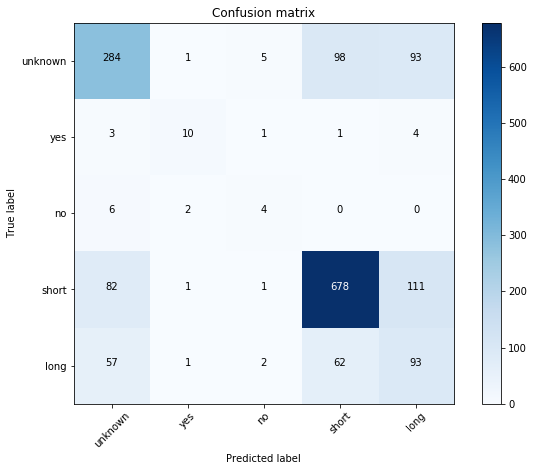

In [16]:
eval_answer_type_result("../output/models/albert-xxlarge-tfidf-600-top8-V0/predictions20000.json")

# Span Extraction Bad Case Analysis

In [20]:
import sys
sys.path.append("../torch_based")
import eval_utils as util
import random

from tqdm import tqdm
from nq_eval import score_long_answer, score_short_answer
from pprint import pprint
from collections import OrderedDict

In [21]:
def get_error_examples(gold_path, prediction_path):
    """Scores all answers for all documents.

    Args:
    gold_annotation_dict: a dict from example id to list of NQLabels.
    pred_dict: a dict from example id to list of NQLabels.

    Returns:
    long_answer_stats: List of scores for long answers.
    short_answer_stats: List of scores for short answers.
    """
    gold_annotation_dict = util.read_simplified_annotation(gold_path)
    pred_dict = util.read_prediction_json(prediction_path)
    gold_id_set = set(gold_annotation_dict.keys())
    pred_id_set = set(pred_dict.keys())

    if gold_id_set.symmetric_difference(pred_id_set):
        raise ValueError(
            'ERROR: the example ids in gold annotations and example '
            'ids in the prediction are not equal.')

    error_examples = {}

    for example_id in tqdm(gold_id_set, desc="Getting error examples..."):
        gold = gold_annotation_dict[example_id]
        pred = pred_dict[example_id]
        gold_has_answer_long, pred_has_answer_long, is_correct_long, _ = score_long_answer(gold, pred)
        gold_has_answer_short, pred_has_answer_short, is_correct_short, _ = score_short_answer(gold, pred)
        if (not (gold_has_answer_long == False and pred_has_answer_long == False) and not is_correct_long) or (not (gold_has_answer_short == False and pred_has_answer_short == False) and not is_correct_short):
            error_examples[example_id] = OrderedDict(gold=gold, pred=pred, gold_has_answer_long=gold_has_answer_long, 
                                              pred_has_answer_long=pred_has_answer_long, is_correct_long=is_correct_long,
                                             gold_has_answer_short=gold_has_answer_short, pred_has_answer_short=pred_has_answer_short,
                                              is_correct_short=is_correct_short)

    return error_examples

In [22]:
def sample_error_example(error_examples, n=30):
    error_examples_keys = list(error_examples.keys())
    for i,k in enumerate(random.sample(error_examples_keys, n)):
        print("Bad Case {}, example_id={}".format(i, k))
        e = error_examples[k]
        gold = e.pop("gold")
        pred = e.pop("pred")
        print("meta data:")
        pprint(e)
        print("\ngold:")
        pprint(gold)
        print("\npred:")
        pprint(pred)
        print("\n----------------------------------------------\n")

In [59]:
error_examples = get_error_examples("../input/tensorflow2-question-answering/simplified-nq-dev.jsonl", "../output/models/bert-large-uncased-whole-word-masking-finetuned-squad/dev_predictions.json")
sample_error_example(error_examples, n=30)

Bad Case 0, example_id=-5359074013301333095
meta data:
OrderedDict([('gold_has_answer_long', False),
             ('pred_has_answer_long', True),
             ('is_correct_long', False),
             ('gold_has_answer_short', False),
             ('pred_has_answer_short', True),
             ('is_correct_short', False)])

gold:
[NQLabel(example_id=-5359074013301333095, long_answer_span=byte: [-1,-1) tok: [-1,-1), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=-5359074013301333095, long_answer_span=byte: [-1,-1) tok: [-1,-1), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=-5359074013301333095, long_answer_span=byte: [-1,-1) tok: [-1,-1), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=-5359074013301333095, long_answer_span=byte: [-1,-1) tok: [-1,-1), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLab

## Round 1 for bert-large-uncased-whole-word-masking-finetuned-squad (2019/12/20)
- 答案段落定位错误：8
- 答案段落定位正确
    - 长答案抽取错误：3
    - 长答案抽取正确
        - 短答案无中生有：4
        - 短答案抽取错误：3
- 长答案无中生有：17

In [24]:
error_examples = get_error_examples("../input/tensorflow2-question-answering/simplified-nq-dev.jsonl", "../output/models/albert-xxlarge-tfidf-600-top8-V0/predictions20000.json")
sample_error_example(error_examples, n=30)

INFO:absl:Reading predictions from file: ../output/models/albert-xxlarge-tfidf-600-top8-V0/predictions20000.json
Getting error examples...: 100%|██████████| 1600/1600 [00:00<00:00, 36090.71it/s]

Bad Case 0, example_id=5758694170037504500
meta data:
OrderedDict([('gold_has_answer_long', True),
             ('pred_has_answer_long', True),
             ('is_correct_long', True),
             ('gold_has_answer_short', False),
             ('pred_has_answer_short', True),
             ('is_correct_short', False)])

gold:
[NQLabel(example_id=5758694170037504500, long_answer_span=byte: [-1,-1) tok: [152,274), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=5758694170037504500, long_answer_span=byte: [-1,-1) tok: [152,274), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=5758694170037504500, long_answer_span=byte: [-1,-1) tok: [152,274), short_answer_span_list=[], yes_no_answer='none', long_score=0, short_score=0),
 NQLabel(example_id=5758694170037504500, long_answer_span=byte: [-1,-1) tok: [152,274), short_answer_span_list=[byte: [-1,-1) tok: [180,204)], yes_no_answer='none', long_sc

## Round 2 for albert-xxlarge-tfidf-600-top8-V0 (2019/12/31)
- 答案段落定位错误：1 [-4141063008045921128]
- 答案段落定位正确
    - 长答案抽取错误：4 [-7372998500277287418]
    - 长答案无中生有：11 [4578427503514934650, -6303212477613295620, -4775436264322432337, 8597450084953159302, 2227239175051205548, -3266897391808103359, 5563733437948017177, -3821358994539922203, 5371299923897887363]
    - 长答案有错认无：2 [8359841237250196144, 2516731105847401467]
    - 短答案无中生有：9 [4578427503514934650, 6483692125446687682, -6303212477613295620, 8597450084953159302, 2227239175051205548, -3266897391808103359, 5563733437948017177, 8200474773719057946, 5371299923897887363]
    - 短答案抽取错误：4 [9199587263422732891, 2985591975335305853, -360675773049242516]
    - 短答案有错认无：3 [4399912168528695468, -7816789034233739974, -6741482021872247759]
